# House Price Prediction

## 1. Install and Import Libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
import optuna.visualization as vis
import sys

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading and Exploration

Training Data Shape: (1460, 80)
Test Data Shape: (1459, 79)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    

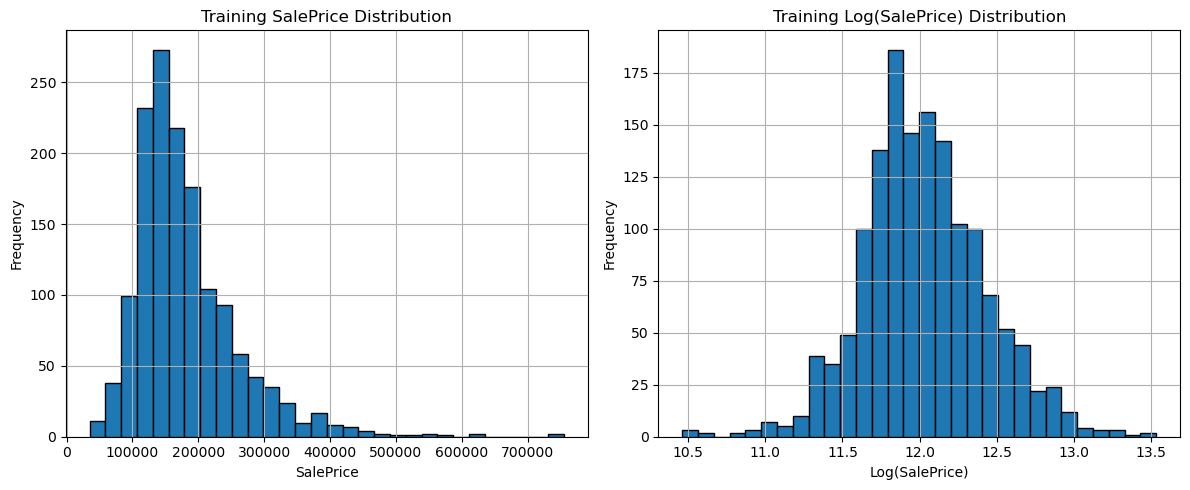

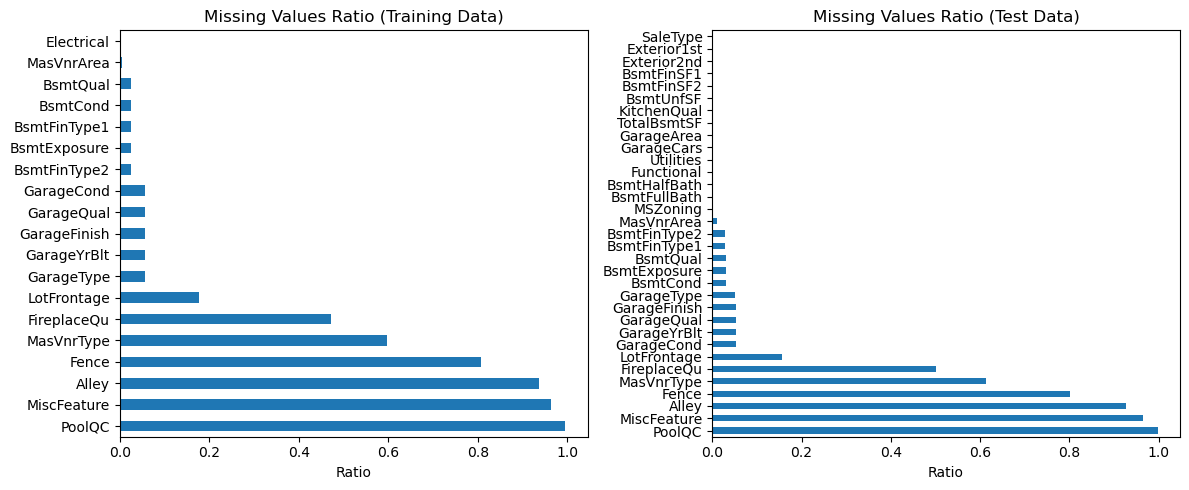

In [18]:
try:
    df_train = pd.read_csv('../data/train.csv')
    df_test = pd.read_csv('../data/test.csv')   
    test_ids = df_test['Id']  
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure 'train.csv' and 'test.csv' are in the current directory or adjust the path.")
    sys.exit(1)

df_train = df_train.drop('Id', axis=1)
df_test = df_test.drop('Id', axis=1)

print('Training Data Shape:', df_train.shape)
print('Test Data Shape:', df_test.shape)
print('\nTraining Data Info:')
df_train.info()

print('\nTraining SalePrice Summary:')
print(df_train['SalePrice'].describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_train['SalePrice'].hist(bins=30, edgecolor='black')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('Training SalePrice Distribution')

plt.subplot(1, 2, 2)
np.log1p(df_train['SalePrice']).hist(bins=30, edgecolor='black')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')
plt.title('Training Log(SalePrice) Distribution')
plt.tight_layout()
plt.show()

missing_ratio_train = df_train.isnull().sum() / len(df_train)
missing_ratio_train = missing_ratio_train[missing_ratio_train > 0].sort_values(ascending=False)

missing_ratio_test = df_test.isnull().sum() / len(df_test)
missing_ratio_test = missing_ratio_test[missing_ratio_test > 0].sort_values(ascending=False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
missing_ratio_train.plot(kind='barh')
plt.title('Missing Values Ratio (Training Data)')
plt.xlabel('Ratio')

plt.subplot(1, 2, 2)
missing_ratio_test.plot(kind='barh')
plt.title('Missing Values Ratio (Test Data)')
plt.xlabel('Ratio')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [19]:
categorical_cols = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
    'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
    'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
    'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
    'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'
]

numerical_cols = [
    'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
    'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
    'MiscVal', 'YrSold'
]

categorical_fill = {
    'PoolQC': 'No Pool', 'MiscFeature': 'None', 'Alley': 'No Alley', 
    'Fence': 'No Fence', 'MasVnrType': 'None', 'FireplaceQu': 'No Fireplace',
    'Exterior1st': 'Other', 'Exterior2nd': 'Other', 'GarageType': 'No Garage',
    'GarageFinish': 'No Garage', 'GarageQual': 'No Garage', 'GarageCond': 'No Garage',
    'BsmtExposure': 'No Basement', 'BsmtFinType2': 'No Basement', 
    'BsmtFinType1': 'No Basement', 'BsmtQual': 'No Basement', 'BsmtCond': 'No Basement'
}

numerical_fill_train = {
    'LotFrontage': df_train['LotFrontage'].median(),
    'GarageYrBlt': df_train['YearBuilt'],
    'MasVnrArea': 0.0,
    'GarageCars': 0,
    'GarageArea': 0,
    'BsmtHalfBath': 0, 'BsmtFullBath': 0,
    'BsmtFinSF1': 0, 'BsmtFinSF2': 0, 'BsmtUnfSF': 0, 'TotalBsmtSF': 0
}

numerical_fill_test = {
    'LotFrontage': df_train['LotFrontage'].median(),  # Use training median
    'GarageYrBlt': df_test['YearBuilt'],
    'MasVnrArea': 0.0,
    'GarageCars': 0,
    'GarageArea': 0,
    'BsmtHalfBath': 0, 'BsmtFullBath': 0,
    'BsmtFinSF1': 0, 'BsmtFinSF2': 0, 'BsmtUnfSF': 0, 'TotalBsmtSF': 0
}

df_train.fillna(categorical_fill, inplace=True)
df_train.fillna(numerical_fill_train, inplace=True)
df_train.dropna(inplace=True)

df_test.fillna(categorical_fill, inplace=True)
df_test.fillna(numerical_fill_test, inplace=True)
df_test.dropna(subset=['MSZoning', 'SaleType', 'Functional', 'KitchenQual', 'Utilities', 'Electrical'], inplace=True)

df_train = df_train[df_train['SalePrice'] < df_train['SalePrice'].quantile(0.99)]  # Remove top 1% SalePrice
df_train = df_train[df_train['GrLivArea'] < df_train['GrLivArea'].quantile(0.99)]  # Remove top 1% GrLivArea

print('Total Missing Values in Training Data:', df_train.isna().sum().sum())
print('Total Missing Values in Test Data:', df_test.isna().sum().sum())

X = df_train.drop('SalePrice', axis=1)
y = np.log1p(df_train['SalePrice'])
X_test = df_test

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(X[col])
    X[col] = le.transform(X[col])
    X_test[col] = X_test[col].apply(lambda x: x if x in le.classes_ else 'Other')
    if 'Other' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'Other')
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

scaler = MinMaxScaler()
scaler.fit(X[numerical_cols])
X[numerical_cols] = scaler.transform(X[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print('Processed Training Data:')
X.head()

Total Missing Values in Training Data: 0
Total Missing Values in Test Data: 0
Processed Training Data:


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,5,3,0.150685,0.033420,1,1,3,3,0,4,0,5,2,2,0,5,6,4,0.949275,0.883333,1,0,12,13,1,0.12250,2,4,2,2,4,3,2,0.375532,6,0.0,0.064212,0.266999,1,0,1,4,0.238356,0.530106,0.0,0.542159,0.333333,0.0,0.666667,0.5,0.500000,0.333333,2,0.6,6,0.000000,3,1,0.949275,2,0.50,0.394245,5,5,2,0.000000,0.111517,0.000000,0.0,0.0,0.0,2,4,1,0.0,1,0.50,8,4
1,0,3,0.202055,0.038795,1,1,3,3,0,2,0,24,1,2,0,2,5,7,0.753623,0.433333,1,0,8,8,2,0.00000,3,4,1,2,4,1,0,0.520213,6,0.0,0.121575,0.393637,1,0,1,4,0.423744,0.000000,0.0,0.365642,0.000000,0.5,0.666667,0.0,0.500000,0.333333,3,0.4,6,0.333333,5,1,0.753623,2,0.50,0.330935,5,5,2,0.347725,0.000000,0.000000,0.0,0.0,0.0,2,4,1,0.0,4,0.25,8,4
2,5,3,0.160959,0.046507,1,1,0,3,0,4,0,5,2,2,0,5,6,4,0.934783,0.866667,1,0,12,13,1,0.10125,2,4,2,2,4,2,2,0.258511,6,0.0,0.185788,0.286962,1,0,1,4,0.267580,0.537554,0.0,0.572104,0.333333,0.0,0.666667,0.5,0.500000,0.333333,2,0.4,6,0.333333,5,1,0.934783,2,0.50,0.437410,5,5,2,0.000000,0.076782,0.000000,0.0,0.0,0.0,2,4,1,0.0,8,0.50,8,4
3,6,3,0.133562,0.038561,1,1,0,3,0,0,0,6,2,2,0,5,6,4,0.311594,0.333333,1,0,13,15,2,0.00000,3,4,0,4,1,3,0,0.114894,6,0.0,0.231164,0.235808,1,2,1,4,0.286301,0.469274,0.0,0.544917,0.333333,0.0,0.333333,0.0,0.500000,0.333333,2,0.5,6,0.333333,2,5,0.913043,3,0.75,0.461871,5,5,2,0.000000,0.063985,0.704663,0.0,0.0,0.0,2,4,1,0.0,1,0.00,8,0
4,5,3,0.215753,0.060576,1,1,0,3,0,2,0,15,2,2,0,5,7,4,0.927536,0.833333,1,0,12,13,1,0.21875,2,4,2,2,4,0,2,0.348404,6,0.0,0.209760,0.357143,1,0,1,4,0.370320,0.653631,0.0,0.734437,0.333333,0.0,0.666667,0.5,0.666667,0.333333,2,0.7,6,0.333333,5,1,0.927536,2,0.75,0.601439,5,5,2,0.224037,0.153565,0.000000,0.0,0.0,0.0,2,4,1,0.0,11,0.50,8,4


## 4. Model Training

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest Regression': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42)
}

predictions = {}
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred_log = model.predict(X_val)
        y_pred = np.expm1(y_pred_log)
        y_val_orig = np.expm1(y_val)
        predictions[name] = y_pred
        rmse = mean_squared_error(y_val_orig, y_pred, squared=False)
        mae = mean_absolute_error(y_val_orig, y_pred)
        r2 = r2_score(y_val_orig, y_pred)
        print(f'{name}:')
        print(f'  RMSE: {rmse:.2f}')
        print(f'  MAE: {mae:.2f}')
        print(f'  R-squared: {r2:.4f}\n')
    except Exception as e:
        print(f"Error training {name}: {e}")


Linear Regression:
  RMSE: 20572.00
  MAE: 14260.93
  R-squared: 0.9045

Lasso Regression:
  RMSE: 41105.57
  MAE: 28404.85
  R-squared: 0.6188

Ridge Regression:
  RMSE: 19925.87
  MAE: 13867.97
  R-squared: 0.9104

Random Forest Regression:
  RMSE: 26366.88
  MAE: 16949.05
  R-squared: 0.8432

XGBoost Regression:
  RMSE: 24204.28
  MAE: 16505.87
  R-squared: 0.8678



## 5. Hyperparameter Tuning with Optuna (Ridge Regression)

[I 2025-08-05 10:10:46,021] A new study created in memory with name: no-name-a70f3c67-e63d-45c3-b9c5-1fca89ca09f0
[I 2025-08-05 10:10:46,095] Trial 0 finished with value: 0.11075110004722413 and parameters: {'alpha': 70.35078897962231}. Best is trial 0 with value: 0.11075110004722413.
[I 2025-08-05 10:10:46,131] Trial 1 finished with value: 0.08936514418968708 and parameters: {'alpha': 1.525552076224195}. Best is trial 1 with value: 0.08936514418968708.
[I 2025-08-05 10:10:46,168] Trial 2 finished with value: 0.11007510358140653 and parameters: {'alpha': 66.74542233312481}. Best is trial 1 with value: 0.08936514418968708.
[I 2025-08-05 10:10:46,203] Trial 3 finished with value: 0.0888673696695671 and parameters: {'alpha': 0.3058827297454218}. Best is trial 3 with value: 0.0888673696695671.
[I 2025-08-05 10:10:46,241] Trial 4 finished with value: 0.0890071640819665 and parameters: {'alpha': 0.1117067030560166}. Best is trial 3 with value: 0.0888673696695671.
[I 2025-08-05 10:10:46,281] 

Best Hyperparameters for Ridge Regression:
{'alpha': 0.53933535663771}
Optimized Ridge Regression on Validation Set:
  MAE: 13880.88
  RMSE: 19946.24
  R-squared: 0.9102


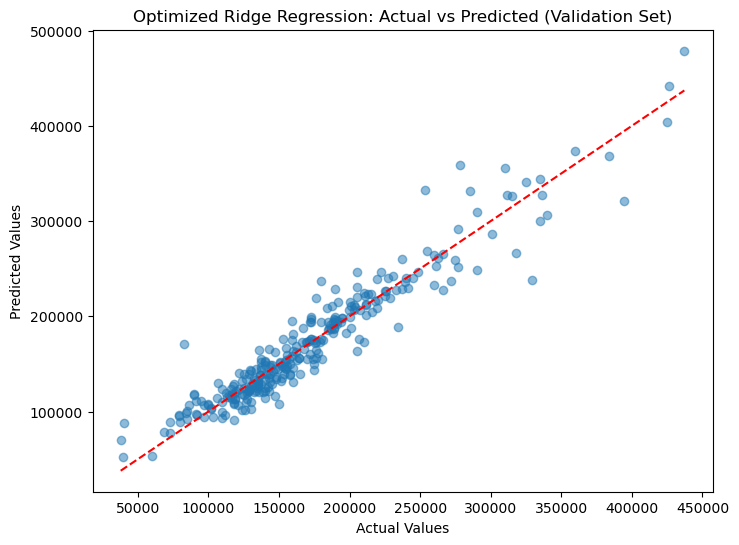

In [21]:
def objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.1, 100.0, log=True)
    }
    
    ridge = Ridge(**params)
    score = cross_val_score(ridge, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    return -score.mean()

try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
except Exception as e:
    print(f"Error during Optuna optimization: {e}")
    sys.exit(1)

print('Best Hyperparameters for Ridge Regression:')
print(study.best_params)

try:
    best_ridge = Ridge(**study.best_params)
    best_ridge.fit(X_train, y_train)
    y_pred_val_log = best_ridge.predict(X_val)
    y_pred_val = np.expm1(y_pred_val_log)
    y_val_orig = np.expm1(y_val)

    print('Optimized Ridge Regression on Validation Set:')
    print(f'  MAE: {mean_absolute_error(y_val_orig, y_pred_val):.2f}')
    print(f'  RMSE: {mean_squared_error(y_val_orig, y_pred_val, squared=False):.2f}')
    print(f'  R-squared: {r2_score(y_val_orig, y_pred_val):.4f}')


    plt.figure(figsize=(8, 6))
    plt.scatter(y_val_orig, y_pred_val, alpha=0.5)
    plt.plot([y_val_orig.min(), y_val_orig.max()], [y_val_orig.min(), y_val_orig.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Optimized Ridge Regression: Actual vs Predicted (Validation Set)')
    plt.show()
except Exception as e:
    print(f"Error evaluating optimized Ridge Regression: {e}")


## 6. Generate Submission File

In [22]:
try:
    y_test_pred_log = best_ridge.predict(X_test)
    y_test_pred = np.expm1(y_test_pred_log)

    submission = pd.DataFrame({
        'Id': test_ids.loc[X_test.index],
        'SalePrice': y_test_pred
    })
    submission.to_csv('submission.csv', index=False)
    print('Submission file generated: submission.csv')
    print(submission.head())
except Exception as e:
    print(f"Error generating submission: {e}")

Submission file generated: submission.csv
     Id      SalePrice
0  1461  121089.792619
1  1462  148909.379664
2  1463  174375.626011
3  1464  194829.185171
4  1465  184065.156806


In [23]:
X_test.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0,2,0.202055,0.048246,1,1,3,3,0,4,0,12,1,2,0,2,4,5,0.644928,0.183333,1,0,12,13,2,0.0,3,4,1,4,4,3,5,0.248936,3,0.097693,0.115582,0.275109,1,4,1,4,0.256621,0.0,0.0,0.221434,0.0,0.0,0.333333,0.0,0.333333,0.333333,3,0.3,6,0.0,3,1,0.644928,3,0.25,0.52518,5,5,2,0.163361,0.0,0.0,0.0,0.25,0.0,2,2,1,0.0,5,1.0,8,4


In [24]:
# change X_test.head(1) to array
X_test = X_test[:1]

In [27]:
X_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0,2,0.202055,0.048246,1,1,3,3,0,4,0,12,1,2,0,2,4,5,0.644928,0.183333,1,0,12,13,2,0.0,3,4,1,4,4,3,5,0.248936,3,0.097693,0.115582,0.275109,1,4,1,4,0.256621,0.0,0.0,0.221434,0.0,0.0,0.333333,0.0,0.333333,0.333333,3,0.3,6,0.0,3,1,0.644928,3,0.25,0.52518,5,5,2,0.163361,0.0,0.0,0.0,0.25,0.0,2,2,1,0.0,5,1.0,8,4
